# Diagnosis extraction from medical reports
### Kivotova Evgenia, B17-DS-01
#### Innopolis University, 2020

In [1]:
import pandas as pd
from bs4 import BeautifulSoup, NavigableString, Tag
from pathlib import Path
from typing import List

## Datasets paths definition

In [2]:
data_dir = Path('datasets')
openi_reports = data_dir / "ecgen-radiology"
russian_reports = data_dir/ "russian"

## OpenI dataset analysis

The OpenI reports are stored in `.xml` format with `UTF-8` encoding.

The body of each report is stored in `<MedlineCitation>` section, namely `<Abstract>` tag. 

Each report consists of 4 parts:
 - `<AbstractText Label="COMPARISON">`- Comparison of the new imaging exam with any available previous exams.
 - `<AbstractText Label="INDICATION">` - The reason for examination or important patient information
 - `AbstractText Label="FINDINGS">` - Detailed  descriptions about normal and abnormal findings
 - `AbstractText Label="IMPRESSION">` - Diseases from Findings and forms a diagnostic conclusion, consisting of abnormal and normal conclusions.
 
Therefore, the **Impression** section is the most valuable one as it contains exact referencies to the diagnosis.

The other interesting section of this reports is `<MeSH>` tag.

**MeSH** stands for Medical Subject Headings, a controlled and hierarchically-organized vocabulary produced by the National Library of Medicine. It is used for indexing, cataloging, and searching of biomedical and health-related information.

It seems to have the keywords about full report that are related to the Impression as well as to the general patient description. 

**BUT!** The `<major>` tag with `normal` value does not overlab with any other tag.

## Reports parsing using BeautifulSoup

In this section the reports are parsed into pandas dataframe, extracting important fields and discarding unnesessary information:

In [3]:
from parsers.russian_parser import Russian
from parsers.openi_parser import OpenI
from utils.text_statistics import DatasetStat

[nltk_data] Downloading package punkt to /home/ekivo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ekivo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ekivo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ekivo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
open_i = OpenI()
open_i.parse_data()
len(open_i.dataset)

3955

In [5]:
open_i.labels

['Calcified Granuloma/lung/upper lobe/left',
 'Deformity/lumbar vertebrae/anterior/multiple/acute/mild',
 'calcified granuloma',
 'deformity',
 'retropulsion',
 'Lumbar Vertebrae',
 'Calcified Granuloma/multiple',
 'Calcinosis/aorta',
 'vascular calcification',
 'Vascular Calcifications',
 'Atherosclerosis/aorta',
 'Aorta/tortuous',
 'Lung/hypoinflation/mild',
 'Aorta',
 'Opacity/lung/lower lobe/left/posterior',
 'Opacity/lung/upper lobe/right/focal',
 'Airspace Disease/lung/lower lobe/left/patchy',
 'granuloma',
 'opacity',
 'pneumonia',
 'scarring',
 'Granulomas',
 'Pneumonia',
 'Scarring',
 'normal',
 'Cardiomegaly',
 'Thoracic Vertebrae/degenerative/mild',
 'degenerative change',
 'Deformity/ribs/right/chronic',
 'old injury',
 'No Indexing',
 'sternotomy',
 'Scoliosis/thoracic vertebrae/right/mild',
 'Implanted Medical Device',
 'Cardiomegaly/borderline',
 'Pacemaker, Artificial',
 'Implanted Medical Device/right',
 'Thoracic Vertebrae/degenerative',
 'Right Atrium',
 'Scoliosis/t

In [6]:
rus_data = Russian()
rus_data.parse_data()
len(rus_data.dataset)

No diagnosis in  74308
No diagnosis in  74319


4682

### Report example

In [7]:
rus_data.dataset[67].text

'Мягкая округлая тень на фоне сердца справа.'

In [8]:
open_i.dataset[69].text

'Cardiomegaly stable. Lungs clear. No edema or effusions'

## Normalization
To perform tokenization, just deletion of unwonted punctuation and the lower case is not enough for Russian language

Before, it is important to resolve reductions:

In [9]:
for report in rus_data.dataset:
    if report.text != 'Норма':
        print(report.id,"->",report.text)

247824 -> Слева в С1-2 инфильтрация л/ткани.Рек: конс. фтизиатра.
202769 -> Уч-к зат-я в сред отд-х л/поля справа+30/4
349381 -> 35,15.Образование над куполом диафрагмы справа.
341632 -> 29\1-2 12\1-2
97356 -> Жидкость в плевральной полости слева
145553 -> продолг тень во 2 м/реб справа
208653 -> Инфильтрация вС3справа отганич.плеврой.
270798 -> Округлое образование в С4 слева.
95662 -> Частичный аталектаз верхней доли правого легкого, жидкость в плевральной полости справа.Расширен правый корень.
172872 -> очаг тени на фоне 3р спр,1 ребра слева.
102345 -> Слева в с-6 мелкофокусная тень
135198 -> участок затен-я в зоне С1 слева
153320 -> Миллиарная диссеминация?
321361 -> 3?,20?/1  15/2
363071 -> Очаги на фоне фиброза в верхушке справа.
215158 -> уч-к затен-я в С10 справа.(пневмония)
100964 -> Справа в С-2 неоднородное затемнение.
90132 -> 16/6Норма
332420 -> Сарава в нижней доле пневмония.
201081 -> справа с1 интенсивное затенение.
136269 -> очаг тени и инф-я в зоне С1-2 справа
184825 

163225 -> В верхних долях очаговые изменения.
156349 -> огранич пневмоторакс справа
146131 -> фокусная тень в 3 м/реб справа
92423 -> участок затен слева 3 4 м/реб
341840 -> слева в прикорневых отделах определяется одиночная очаговая тень в S6
91318 -> 12,16/6 норма
78499 -> вызов
206744 -> плотныеочаговые изменения в 1 межреберье справа и 2 межреберье слева
90626 -> 16/6Норма
273462 -> Инфильтрация в проекции С4 слева.
191196 -> саркоидоз л-х
121324 -> очаг тени и фибр тяжи в С1-С2 с обеих сторон
130228 -> очаг тени в зоне С2 справа динам отр-ая.
282609 -> Усиление идеформация легочного рисунка за счет сосудистого компонента. Корни полнокровны. Сердце увеличено.
153732 -> участок затенения во 2 м/реб справа
141252 -> инфильтрация язычковых сегментов слева
192723 -> крупный фокус затенения в верхнем легочном поле справа
156827 -> Справа с1+2 затенение. 26/3
274559 -> В праваом корне округлые образования.
333886 -> очаговая тень во 2 м/реб-е слева латер-но.
91387 -> 16/1,4Норма
354823 -

294821 -> справа в S10 определяется инфильтрация легочной ткани в звднем синусе справа выпот
350983 -> Очаговые тени в 1-м межреберье справа.
271373 -> Инфильтрация в С 3 справа и С 5 слева отграниченная сегментарной плеврой.
182397 -> очаговые изменеия в 1 межреберье справа
79688 -> 35,7
91237 -> 21Норма
187950 -> справа с1+2 очаговая тень
280677 -> слева в С1-С2 фибр тяжи и очаг тени?
136179 -> Очаговая тень в среднем легочном поле справа?
359072 -> Округлое образование примыкающее к правому контуру тени сердца
275641 -> Корни расширены, уплотнены.
346804 -> Корни расширены,уплотнены,полицикличны.
258766 -> Множественные полиморфные очаговые тени в верхней доле левого легкого.
10080 -> корни расширены, уплотнены, полицикличны
89273 -> 21
268658 -> интенс очаг тень в зоне С1-С2 справа мед-но.
175930 -> Мелкоочаговая диссеминация в верхних легочных полях с обеих сторон
290637 -> Очаговая тень на уровне 2-го ребра слева. Корень слева расширен.
84125 -> вызов
195280 -> левосторонняя н/до

In [10]:
for report in rus_data.dataset:
    if report.text == 'Норма':
        print(report.id,"->",report.text)

89391 -> Норма
91510 -> Норма
91275 -> Норма
91503 -> Норма
91177 -> Норма
89612 -> Норма
91541 -> Норма
90462 -> Норма
90278 -> Норма
89738 -> Норма
90907 -> Норма
89895 -> Норма
91172 -> Норма
90357 -> Норма
90124 -> Норма
90832 -> Норма
90492 -> Норма
90420 -> Норма
91558 -> Норма
90889 -> Норма
91007 -> Норма
89451 -> Норма
91278 -> Норма
89353 -> Норма
90451 -> Норма
89758 -> Норма
89658 -> Норма
90168 -> Норма
89354 -> Норма
91140 -> Норма
91349 -> Норма
89668 -> Норма
91336 -> Норма
91008 -> Норма
91065 -> Норма
90946 -> Норма
90315 -> Норма
90428 -> Норма
90240 -> Норма
89470 -> Норма
91373 -> Норма
90186 -> Норма
89501 -> Норма
89660 -> Норма
91045 -> Норма
91218 -> Норма
90358 -> Норма
90547 -> Норма
91250 -> Норма
91565 -> Норма
90203 -> Норма
89260 -> Норма
90531 -> Норма
90058 -> Норма
90264 -> Норма
90772 -> Норма
90732 -> Норма
91570 -> Норма
90220 -> Норма
90664 -> Норма
91498 -> Норма
90812 -> Норма
89552 -> Норма
89651 -> Норма
91265 -> Норма
90631 -> Норма
91347 -> Н

91080 -> Норма
89798 -> Норма
89765 -> Норма
90577 -> Норма
91178 -> Норма
91058 -> Норма
91399 -> Норма
90566 -> Норма
91418 -> Норма
90724 -> Норма
89553 -> Норма
90465 -> Норма
91092 -> Норма
91289 -> Норма
89474 -> Норма
89589 -> Норма
90061 -> Норма
89782 -> Норма
89581 -> Норма
90701 -> Норма
89277 -> Норма
89913 -> Норма
91550 -> Норма
91422 -> Норма
89255 -> Норма
89507 -> Норма
90771 -> Норма
90807 -> Норма
89837 -> Норма
90265 -> Норма
89351 -> Норма
90212 -> Норма
90703 -> Норма
90594 -> Норма
89817 -> Норма
89435 -> Норма
89954 -> Норма
90029 -> Норма
90064 -> Норма
91606 -> Норма
89544 -> Норма
91376 -> Норма
89513 -> Норма
89410 -> Норма
91346 -> Норма
90795 -> Норма
90749 -> Норма
90485 -> Норма
91427 -> Норма
91215 -> Норма
90592 -> Норма
91026 -> Норма
90292 -> Норма
90775 -> Норма
91232 -> Норма
89498 -> Норма
90125 -> Норма
89452 -> Норма
90736 -> Норма
91383 -> Норма
89663 -> Норма
89742 -> Норма
90295 -> Норма
90639 -> Норма
90667 -> Норма
90490 -> Норма
90615 -> Н

## Tockenisation
The tokenisation is done using nltk.word_tokenise

In [11]:
from utils.text_preprocessing import tokenize, lemmatization, remove_stop_words

In [12]:
tokenize(rus_data.dataset[4].text)

['Уч-к', 'зат-я', 'в', 'сред', 'отд-х', 'л/поля', 'справа+30/4']

In [13]:
tokenize(rus_data.dataset[5].text)

['35,15.Образование', 'над', 'куполом', 'диафрагмы', 'справа', '.']

In [14]:
tokenize(rus_data.dataset[13].text)

['продолг', 'тень', 'во', '2', 'м/реб', 'справа']

## Lemmatization

### NLTK WordNetLemmatizer
Does n ot seems to work

In [15]:
lemmatization(tokenize(rus_data.dataset[4].text))

['Уч-к', 'зат-я', 'в', 'сред', 'отд-х', 'л/поля', 'справа+30/4']

### pymorphy2.MorphAnalyzer

In [16]:
from pymorphy2 import MorphAnalyzer

In [17]:
def morph_analysis(tokens):
    result = []
    for token in tokens:
        result.append(
            set(w.normal_form for w in MorphAnalyzer().parse(token)))
    return result

In [18]:
morph_analysis(tokenize(rus_data.dataset[4].text))

[{'уч-к', 'уч-как', 'уч-кандидат'},
 {'зат-я'},
 {'в', 'век'},
 {'среда'},
 {'отд-х', 'отд-ха', 'отд-хий', 'отд-хнуть'},
 {'л/поле', 'л/полоть', 'л/поль', 'л/поля'},
 {'справа+30/4'}]

## Stop words
Using nltk.corpus.stopwords

In [19]:
remove_stop_words(tokenize(rus_data.dataset[4].text), lang='russian')

['Уч-к', 'зат-я', 'сред', 'отд-х', 'л/поля', 'справа+30/4']

## Full statistics analysis
Example on OpenI

In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
stat = DatasetStat()
stat.calculate_statistics(open_i.dataset)

### Distribution

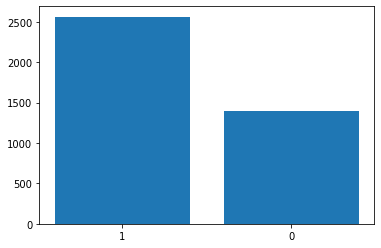

In [22]:
labels = {}
for report in open_i.dataset:
    if not report.label in labels:
        labels[report.label] = 1
    else:
        labels[report.label] += 1
plt.bar([0,1],labels.values())
plt.xticks([0,1], labels.keys())
plt.show()

### Mean length
measured in tokens

In [23]:
stat.mean_doc_length

8.141087231352719

In [24]:
stat.mean_doc_length_by_label

{'1': 10.121684867394697, '0': 4.490294751976995}

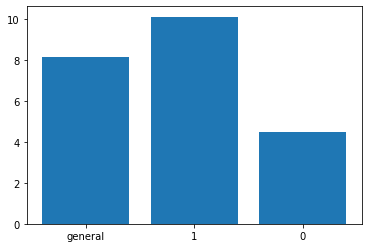

In [25]:
lengths = {}
lengths['general'] = stat.mean_doc_length
for key,value in stat.mean_doc_length_by_label.items():
    lengths[key] = value
y_pos = np.arange(len(lengths.keys()))
plt.bar(y_pos,lengths.values())
plt.xticks(y_pos,lengths.keys() )
plt.show()

### Words frequency

In [26]:
def plot_pie(counter, amount):
    data = counter.most_common(amount)
    labels = list(map((lambda x:x[0]),data))
    values = list(map((lambda x:x[1]),data))
    other_size = sum(counter.values()) - sum(values)
    labels.append('OTHER')
    values.append(other_size)

    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=10, explode=[1]*len(values))
    ax1.axis('equal')  
    plt.show()

In [27]:
stat.words_frequency.most_common(50)

[('acute', 2357),
 ('cardiopulmonary', 1644),
 ('xxxx', 1200),
 ('disease', 1088),
 ('abnormality', 1032),
 ('1', 850),
 ('lung', 761),
 ('right', 601),
 ('normal', 528),
 ('finding', 520),
 ('left', 507),
 ('pulmonary', 505),
 ('chest', 420),
 ('effusion', 418),
 ('2', 417),
 ('clear', 389),
 ('pleural', 375),
 ('active', 359),
 ('heart', 358),
 ('process', 341),
 ('size', 335),
 ('evidence', 318),
 ('stable', 314),
 ('atelectasis', 295),
 ('cardiomegaly', 260),
 ('opacity', 247),
 ('airspace', 213),
 ('lobe', 207),
 ('change', 206),
 ('mild', 202),
 ('edema', 186),
 ('without', 178),
 ('mediastinal', 174),
 ('may', 166),
 ('focal', 163),
 ('pneumothorax', 161),
 ('upper', 157),
 ('within', 155),
 ('pneumonia', 151),
 ('radiographic', 150),
 ('limit', 149),
 ('nodule', 135),
 ('small', 135),
 ('negative', 134),
 ('consolidation', 134),
 ('identified', 132),
 ('lower', 130),
 ('volume', 130),
 ('bilateral', 125),
 ('base', 122)]

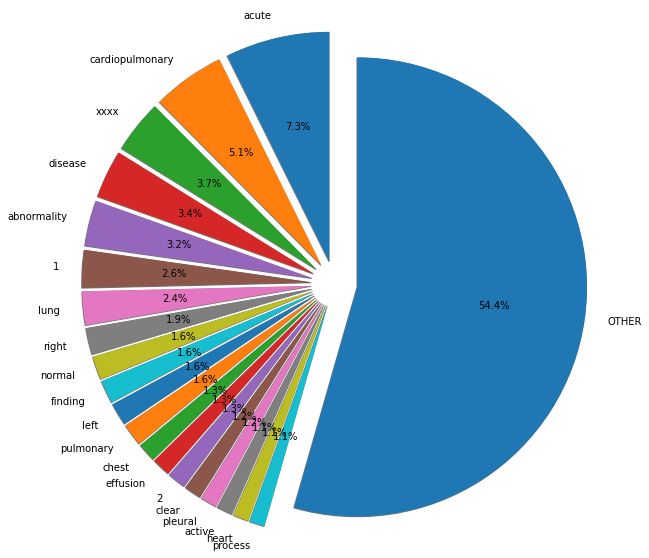

In [28]:
plot_pie(stat.words_frequency,20)

### Words frequenct by label

#### Normal (0)

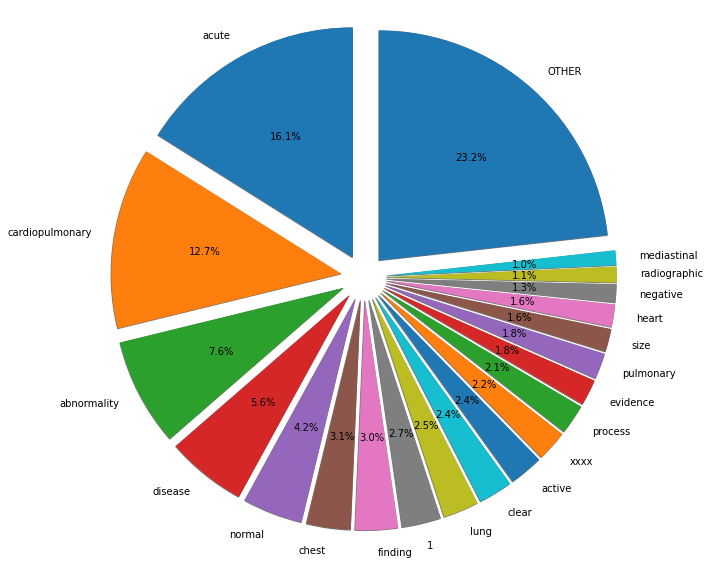

In [29]:
plot_pie(stat.words_frequency_by_label['0'],20)

#### With tag (1)

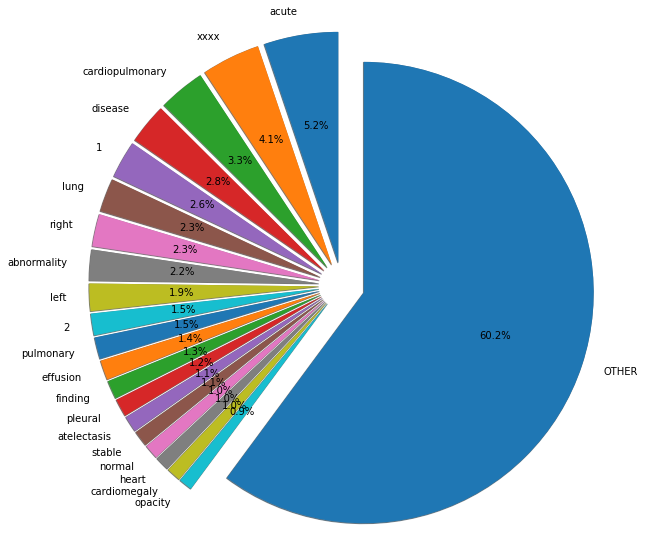

In [30]:
plot_pie(stat.words_frequency_by_label['1'],20)


### Document frequency

In [31]:
stat.doc_frequency.most_common(20)

[('acute', 2323),
 ('cardiopulmonary', 1643),
 ('disease', 1047),
 ('abnormality', 1025),
 ('1', 829),
 ('lung', 686),
 ('xxxx', 672),
 ('finding', 512),
 ('right', 463),
 ('normal', 455),
 ('pulmonary', 453),
 ('2', 412),
 ('left', 412),
 ('effusion', 403),
 ('chest', 401),
 ('clear', 385),
 ('active', 356),
 ('heart', 354),
 ('pleural', 345),
 ('process', 341)]

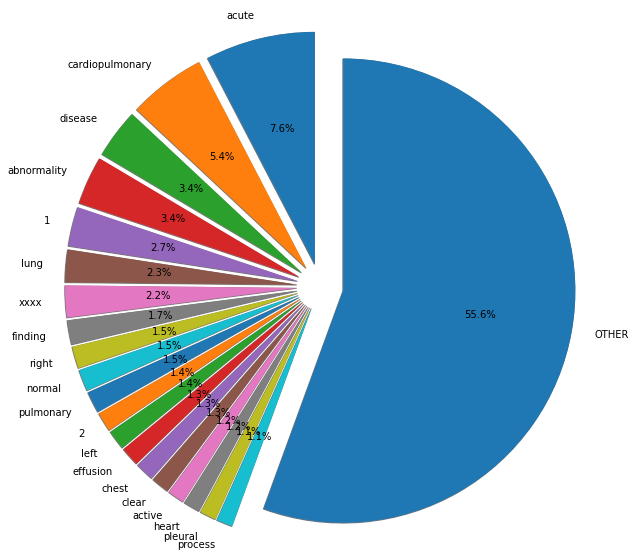

In [32]:
plot_pie(stat.doc_frequency,20)

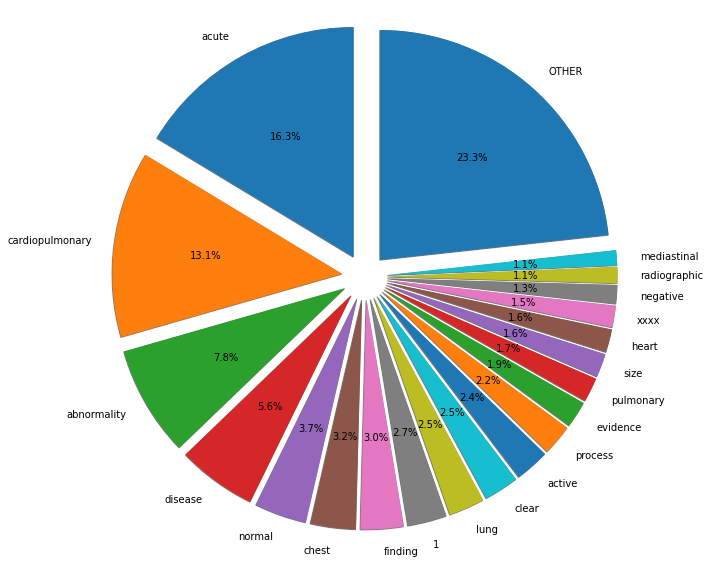

In [34]:
plot_pie(stat.doc_frequency_by_label['0'],20)

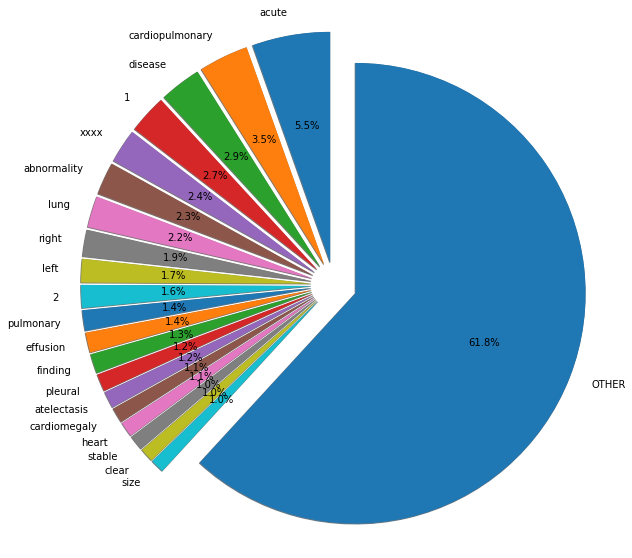

In [35]:
plot_pie(stat.doc_frequency_by_label['1'],20)

### Part of speech frequency

In [ ]:
stat.tag_frequency.most_common(20)

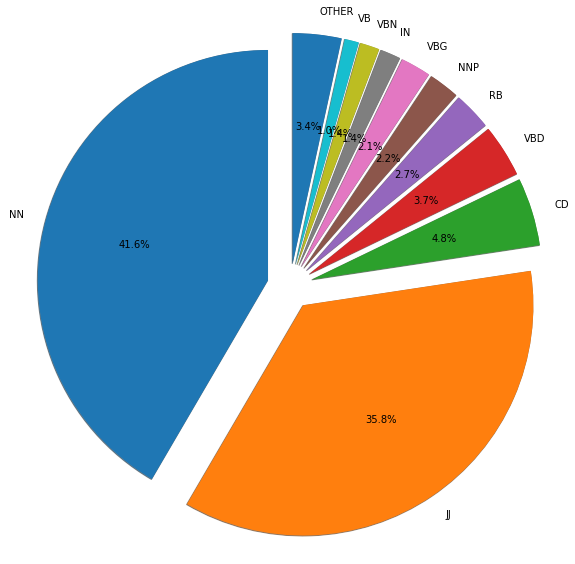

In [36]:
plot_pie(stat.tag_frequency,10)


## Russian dataset kind of analysis

In [ ]:
stat = DatasetStat()
stat.calculate_statistics(rus_data.dataset, lang='russian')

In [ ]:
stat.mean_doc_length

In [8]:
stat.mean_doc_length_by_label

{'норма': 1.0917235494880546, 'патология': 6.033361847733105}

In [9]:
stat.words_frequency.most_common(20)

[('норма', 2166),
 ('справа', 912),
 ('слева', 719),
 ('тень', 533),
 ('2', 459),
 ('тени', 415),
 ('1', 345),
 ('очаг', 335),
 ('инфильтрация', 246),
 ('с1', 244),
 ('3', 239),
 ('м', 234),
 ('очаговые', 233),
 ('очаговая', 232),
 ('5', 211),
 ('4', 190),
 ('реб', 147),
 ('межреберье', 140),
 ('л', 132),
 ('зоне', 132)]